In [50]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import catboost as cat
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from dateutil.easter import easter
from datetime import timedelta
import re

color_pal = sns.color_palette()

In [2]:
data = pd.read_parquet(
    r"D:\Ecole-Polytechnique\M1\Python-for-Data-Science\Project\Bike-Counters-Ameya---Qiling\data\train.parquet"
)

In [3]:
test_data = pd.read_parquet(
    r"D:\Ecole-Polytechnique\M1\Python-for-Data-Science\Project\Bike-Counters-Ameya---Qiling\data\test.parquet"
)

In [4]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [5]:
data["date"] = pd.to_datetime(data["date"])

In [6]:
data = data.set_index("date")

In [7]:
test_data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
56474,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 05:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
56477,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2021-08-10 06:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.098612
56480,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 07:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
56483,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2021-08-10 09:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
56486,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2021-08-10 10:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147


In [8]:
test_data["date"] = pd.to_datetime(test_data["date"])
test_data = test_data.set_index("date")

In [9]:
train = data[["counter_name", "log_bike_count"]]
test = test_data[["counter_name", "log_bike_count"]]

In [10]:
# train.drop("counter_name", axis=1, inplace=True)

In [11]:
# test.drop("counter_name", axis=1, inplace=True)

In [12]:
train.head()

,counter_name,log_bike_count
date,,
2020-09-01 02:00:00,28 boulevard Diderot E-O,0.000000
2020-09-01 03:00:00,28 boulevard Diderot E-O,0.693147
2020-09-01 04:00:00,28 boulevard Diderot E-O,0.000000
2020-09-01 15:00:00,28 boulevard Diderot E-O,1.609438
2020-09-01 18:00:00,28 boulevard Diderot E-O,2.302585


In [13]:
test.head()

,counter_name,log_bike_count
date,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612
2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147
2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000
2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147


In [14]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

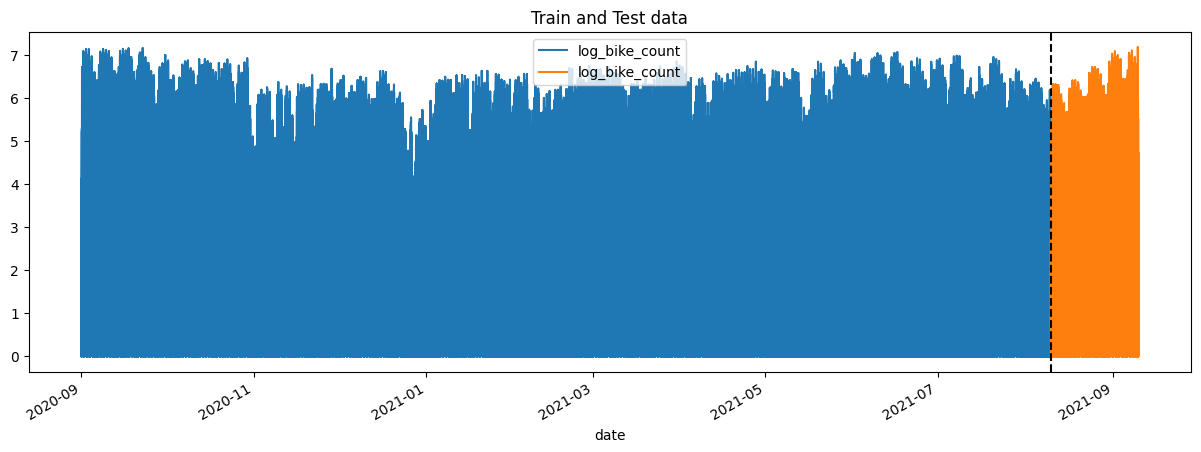

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set", title="Train and Test data")
test.plot(ax=ax, label="Testing Set")
ax.axvline("2021-08-10 02:00:00", color="black", ls="--")
ax.legend
plt.show()

<Axes: xlabel='date'>

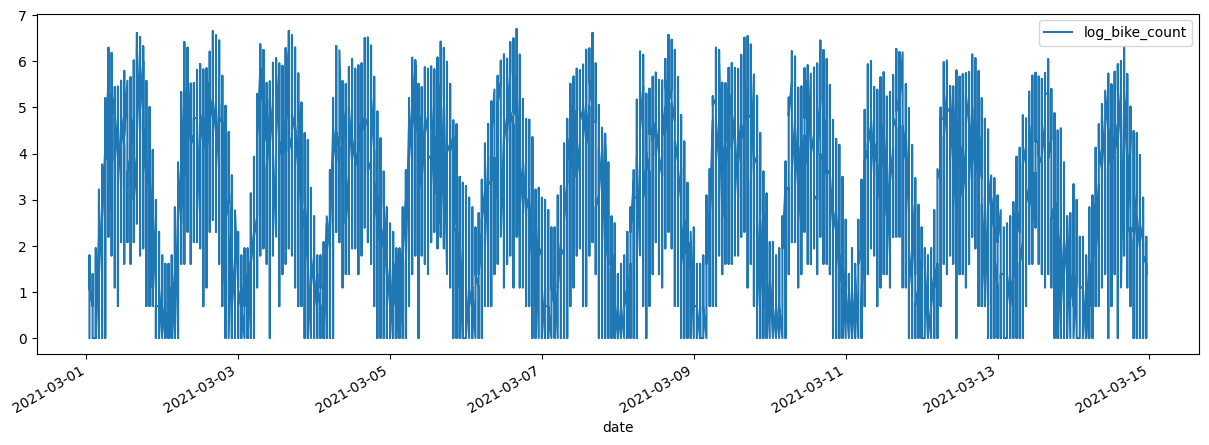

In [16]:
train.loc[(train.index > "2021-03-01") & (train.index < "2021-03-15")].plot(
    figsize=(15, 5)
)

<Axes: xlabel='date'>

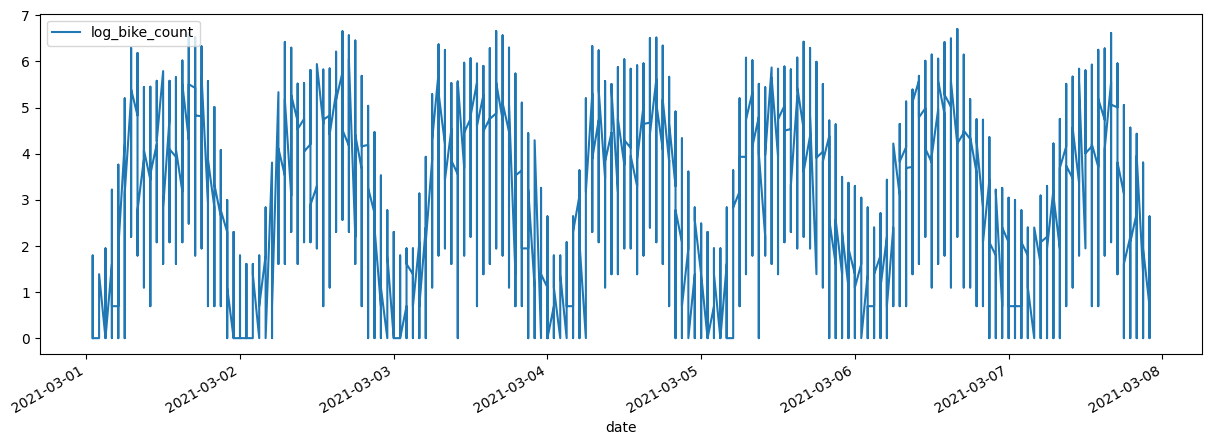

In [17]:
train.loc[
    (train.index > "2021-03-01 00:00:00") & (train.index < "2021-03-07 23:00:00")
].plot(figsize=(15, 5))

In [18]:
# Class for adding French holidays
class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1),
        Holiday("Labour Day", month=5, day=1),
        Holiday("Victory in Europe Day", month=5, day=8),
        Holiday("Bastille Day", month=7, day=14),
        Holiday("Assumption of Mary", month=8, day=15),
        Holiday("All Saints' Day", month=11, day=1),
        Holiday("Armistice Day", month=11, day=11),
        Holiday("Christmas Day", month=12, day=25),
    ]

    @staticmethod
    def easter_related_holidays(year):
        easter_sunday = easter(year)
        return [
            (easter_sunday + timedelta(days=1), "Easter Monday"),
            (easter_sunday + timedelta(days=39), "Ascension Day"),
        ]


# Function to add cyclical features of hour and day
def cyclical_encode(df, column, max_value):
    df[column + "_sin"] = np.sin(2 * np.pi * df[column] / max_value)
    df[column + "_cos"] = np.cos(2 * np.pi * df[column] / max_value)
    return df


# Function to create timeseries features
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear

    # Boolean for weekends
    df["is_weekend"] = df["dayofweek"].isin([5, 6])

    # cyclical
    df = cyclical_encode(df, "hour", 24)
    df = cyclical_encode(df, "dayofweek", 7)

    # Boolean for holidays
    cal = FrenchHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max())
    easter_holidays = []

    for year in range(df.index.year.min(), df.index.year.max() + 1):
        for date, _ in FrenchHolidayCalendar.easter_related_holidays(year):
            easter_holidays.append(date)

    holidays = holidays.union(pd.to_datetime(easter_holidays))

    df["is_holiday"] = df.index.isin(holidays)

    # Lockdown periods
    lockdowns = {
        "lockdown_1": ("2020-03-17", "2020-05-10"),
        "lockdown_2": ("2020-10-28", "2020-12-01"),
        # with curfew from 7 PM to 6 AM
        "lockdown_3_1": ("2021-04-03 19:00:00", "2021-05-18 06:00:00"),
        # with curfew from 9 PM to 6 AM
        "lockdown_3_2": ("2021-05-19 21:00:00", "2021-06-08 06:00:00"),
        # with curfew from 11 PM to 6 AM
        "lockdown_3_3": ("2021-06-09 23:00:00", "2021-06-29 06:00:00"),
    }

    for lockdown, (start_date, end_date) in lockdowns.items():
        mask = (df.index >= start_date) & (df.index <= end_date)
        df[lockdown] = mask
    return df

In [19]:
data = create_features(data)

In [20]:
train = create_features(train)
test = create_features(test)

In [21]:
train.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,is_holiday,lockdown_1,lockdown_2,lockdown_3_1,lockdown_3_2,lockdown_3_3
date,,,,,,,,,,,,,,,,,,
2020-09-01 02:00:00,28 boulevard Diderot E-O,0.000000,2,1,3,9,245,False,0.500000,8.660254e-01,0.781831,0.62349,False,False,False,False,False,False
2020-09-01 03:00:00,28 boulevard Diderot E-O,0.693147,3,1,3,9,245,False,0.707107,7.071068e-01,0.781831,0.62349,False,False,False,False,False,False
2020-09-01 04:00:00,28 boulevard Diderot E-O,0.000000,4,1,3,9,245,False,0.866025,5.000000e-01,0.781831,0.62349,False,False,False,False,False,False
2020-09-01 15:00:00,28 boulevard Diderot E-O,1.609438,15,1,3,9,245,False,-0.707107,-7.071068e-01,0.781831,0.62349,False,False,False,False,False,False
2020-09-01 18:00:00,28 boulevard Diderot E-O,2.302585,18,1,3,9,245,False,-1.000000,-1.836970e-16,0.781831,0.62349,False,False,False,False,False,False


In [22]:
test.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,is_holiday,lockdown_1,lockdown_2,lockdown_3_1,lockdown_3_2,lockdown_3_3
date,,,,,,,,,,,,,,,,,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147,5,1,3,8,222,False,0.965926,2.588190e-01,0.781831,0.62349,False,False,False,False,False,False
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612,6,1,3,8,222,False,1.000000,6.123234e-17,0.781831,0.62349,False,False,False,False,False,False
2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147,7,1,3,8,222,False,0.965926,-2.588190e-01,0.781831,0.62349,False,False,False,False,False,False
2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000,9,1,3,8,222,False,0.707107,-7.071068e-01,0.781831,0.62349,False,False,False,False,False,False
2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147,10,1,3,8,222,False,0.500000,-8.660254e-01,0.781831,0.62349,False,False,False,False,False,False


Visualize our Feature/Target Relationship

Text(0.5, 1.0, 'Bike Counts by Hour')

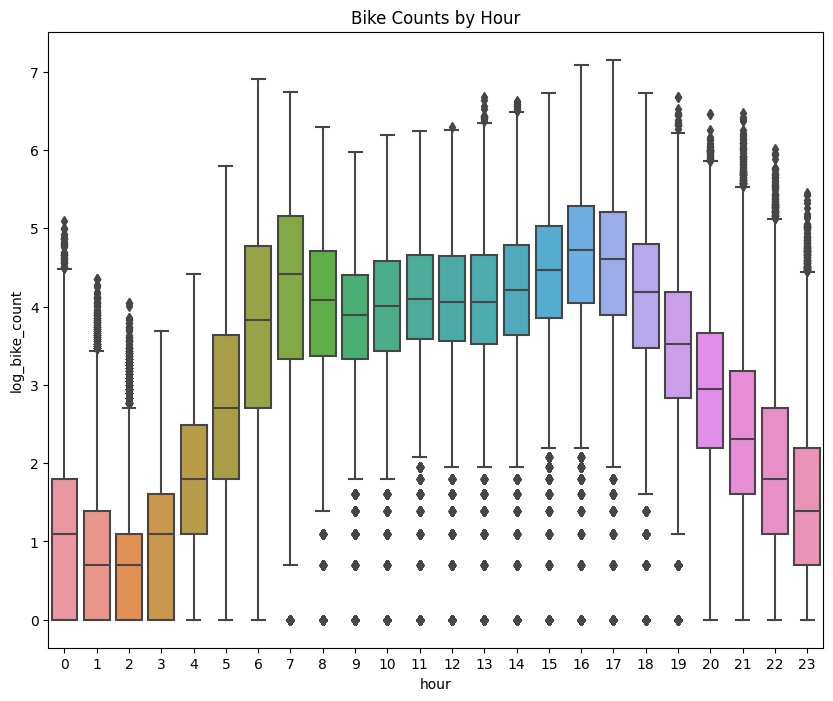

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train, x="hour", y="log_bike_count")
ax.set_title("Bike Counts by Hour")

Text(0.5, 1.0, 'Test Bike Counts by Hour')

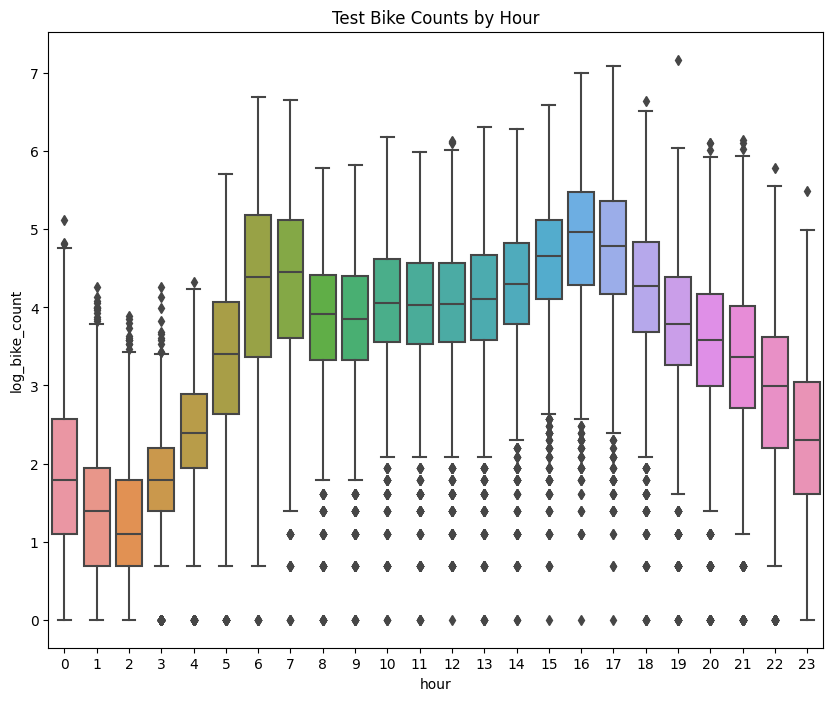

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=test, x="hour", y="log_bike_count")
ax.set_title("Test Bike Counts by Hour")

Text(0.5, 1.0, 'Bike Counts by Months')

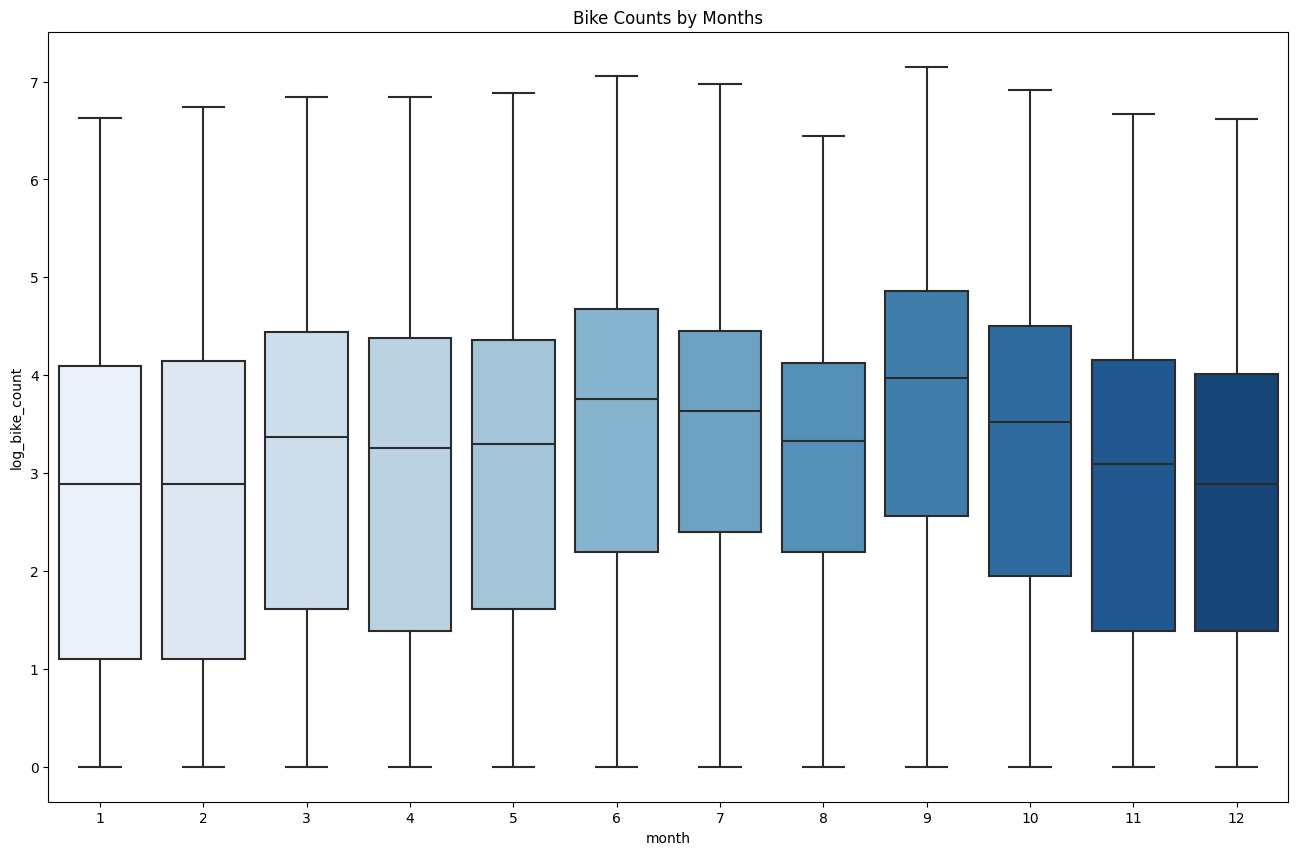

In [25]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(data=train, x="month", y="log_bike_count", palette="Blues")
ax.set_title("Bike Counts by Months")

Text(0.5, 1.0, 'Test Bike Counts by Months')

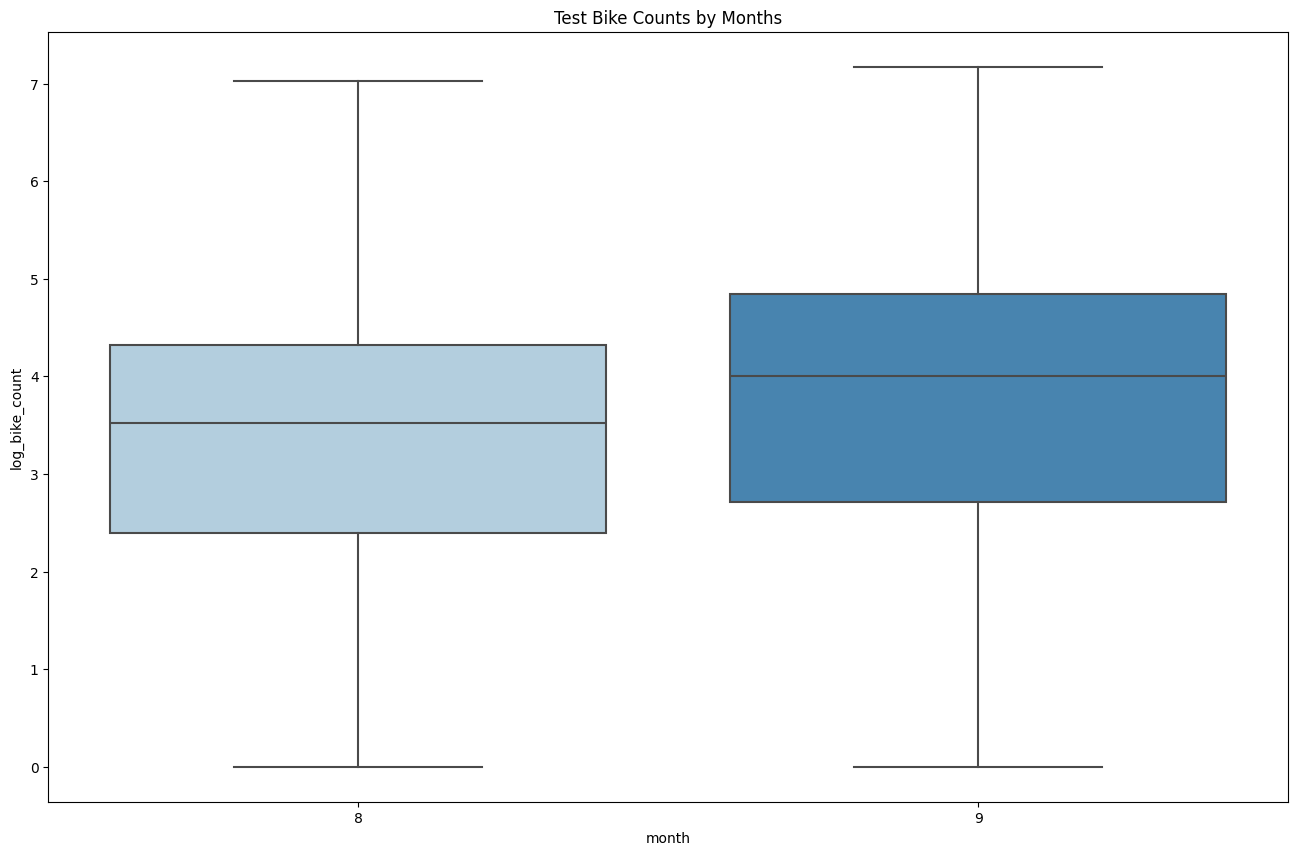

In [26]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.boxplot(data=test, x="month", y="log_bike_count", palette="Blues")
ax.set_title("Test Bike Counts by Months")

In [27]:
# converting boolean to int so that XGBoost's 'hist' tree method can use them with no problems
boolean_columns = [
    "is_weekend",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]

for column in boolean_columns:
    train[column] = train[column].astype(int)

for column in boolean_columns:
    test[column] = test[column].astype(int)

Create our Model

In [28]:
features = [
    "counter_name",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "dayofyear",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "dayofweek_sin",
    "dayofweek_cos",
    "is_holiday",
    "lockdown_1",
    "lockdown_2",
    "lockdown_3_1",
    "lockdown_3_2",
    "lockdown_3_3",
]


target = ["log_bike_count"]


cat_feature = ["counter_name"]

In [29]:
reg = xgb.XGBRegressor(
    tree_method="hist", n_estimators=1000, enable_categorical=True)

In [54]:
cat_reg = cat.CatBoostRegressor(n_estimators=1000)

In [30]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [31]:
X_train.head()

,counter_name,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,is_holiday,lockdown_1,lockdown_2,lockdown_3_1,lockdown_3_2,lockdown_3_3
date,,,,,,,,,,,,,,,,,
2020-09-01 02:00:00,28 boulevard Diderot E-O,2,1,3,9,245,0,0.500000,8.660254e-01,0.781831,0.62349,0,0,0,0,0,0
2020-09-01 03:00:00,28 boulevard Diderot E-O,3,1,3,9,245,0,0.707107,7.071068e-01,0.781831,0.62349,0,0,0,0,0,0
2020-09-01 04:00:00,28 boulevard Diderot E-O,4,1,3,9,245,0,0.866025,5.000000e-01,0.781831,0.62349,0,0,0,0,0,0
2020-09-01 15:00:00,28 boulevard Diderot E-O,15,1,3,9,245,0,-0.707107,-7.071068e-01,0.781831,0.62349,0,0,0,0,0,0
2020-09-01 18:00:00,28 boulevard Diderot E-O,18,1,3,9,245,0,-1.000000,-1.836970e-16,0.781831,0.62349,0,0,0,0,0,0


In [34]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [35]:
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, cat_feature)],
    remainder="passthrough",
)

In [36]:
base_estimator = DecisionTreeRegressor()

In [37]:
ada_boost_model = AdaBoostRegressor(
    base_estimator=base_estimator, n_estimators=100, random_state=42
)

In [45]:
xgb_model = xgb.XGBRegressor()

In [53]:
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", cat_reg)])

In [54]:
pipeline.fit(X_train, y_train.values.ravel())

Learning rate set to 0.107689
0:	learn: 1.5705254	total: 102ms	remaining: 1m 42s
1:	learn: 1.4811681	total: 127ms	remaining: 1m 3s
2:	learn: 1.4051769	total: 146ms	remaining: 48.4s
3:	learn: 1.3402127	total: 163ms	remaining: 40.6s
4:	learn: 1.2843398	total: 181ms	remaining: 36s
5:	learn: 1.2351455	total: 200ms	remaining: 33.1s
6:	learn: 1.1923497	total: 217ms	remaining: 30.8s
7:	learn: 1.1557438	total: 234ms	remaining: 29.1s
8:	learn: 1.1244338	total: 251ms	remaining: 27.6s
9:	learn: 1.0921527	total: 269ms	remaining: 26.6s
10:	learn: 1.0684732	total: 286ms	remaining: 25.7s
11:	learn: 1.0472620	total: 302ms	remaining: 24.9s
12:	learn: 1.0280577	total: 319ms	remaining: 24.2s
13:	learn: 1.0086546	total: 336ms	remaining: 23.7s
14:	learn: 0.9945035	total: 352ms	remaining: 23.1s
15:	learn: 0.9799154	total: 372ms	remaining: 22.9s
16:	learn: 0.9680164	total: 389ms	remaining: 22.5s
17:	learn: 0.9574902	total: 408ms	remaining: 22.3s
18:	learn: 0.9475875	total: 426ms	remaining: 22s
19:	learn: 0.9

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x000001B8EBA63370>)])

In [55]:
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.408353864558275


In [32]:
reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

[0]	validation_0-rmse:2.21313	validation_1-rmse:2.36521
[10]	validation_0-rmse:0.57309	validation_1-rmse:0.53558


c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.47970	validation_1-rmse:0.45625
[30]	validation_0-rmse:0.44736	validation_1-rmse:0.45121
[40]	validation_0-rmse:0.42716	validation_1-rmse:0.44005
[50]	validation_0-rmse:0.41277	validation_1-rmse:0.43328
[60]	validation_0-rmse:0.40376	validation_1-rmse:0.43189
[70]	validation_0-rmse:0.39551	validation_1-rmse:0.42840
[79]	validation_0-rmse:0.38829	validation_1-rmse:0.43065


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
cat_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

Learning rate set to 0.133115
0:	learn: 1.5285781	test: 1.5283890	test1: 1.3457365	best: 1.3457365 (0)	total: 323ms	remaining: 5m 22s
10:	learn: 0.9061010	test: 0.9041412	test1: 0.7821185	best: 0.7821185 (10)	total: 1.34s	remaining: 2m
20:	learn: 0.7797993	test: 0.7768433	test1: 0.6806251	best: 0.6806251 (20)	total: 2.48s	remaining: 1m 55s
30:	learn: 0.7373574	test: 0.7341106	test1: 0.6319129	best: 0.6319129 (30)	total: 3.67s	remaining: 1m 54s
40:	learn: 0.7111332	test: 0.7074448	test1: 0.6100430	best: 0.6100430 (40)	total: 4.92s	remaining: 1m 55s
50:	learn: 0.6949541	test: 0.6911342	test1: 0.5920938	best: 0.5920938 (50)	total: 6.18s	remaining: 1m 55s
60:	learn: 0.6609359	test: 0.6571133	test1: 0.5865411	best: 0.5865411 (60)	total: 7.48s	remaining: 1m 55s
70:	learn: 0.6364383	test: 0.6322085	test1: 0.5584359	best: 0.5584359 (70)	total: 8.73s	remaining: 1m 54s
80:	learn: 0.6247673	test: 0.6202571	test1: 0.5514453	best: 0.5514453 (80)	total: 9.98s	remaining: 1m 53s
90:	learn: 0.6148611	t

In [32]:
ada_reg.fit(X_train, y_train)

c:\Users\ameya\miniforge-pypy3\envs\bikes-count\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: could not convert string to float: '254 rue de Vaugirard NE-SO'

In [33]:
y_hat_xgb = reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

# y_hat_cat = cat_reg.predict(X_train)
# rmse_cat_train = mean_squared_error(y_train, y_hat_cat, squared=False)
# print("CAT Train:", rmse_cat_train)

XGB Train: 0.39628110010541767


In [34]:
y_pred_xgb = reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

# y_test_cat = cat_reg.predict(X_test)
# rmse_cat_test = mean_squared_error(y_test, y_test_cat, squared=False)
# print("CAT Test:", rmse_cat_test)

XGB Test: 0.42839758662117466


In [35]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=[
        "Importance"]
)

<Axes: title={'center': 'Feature Importances'}>

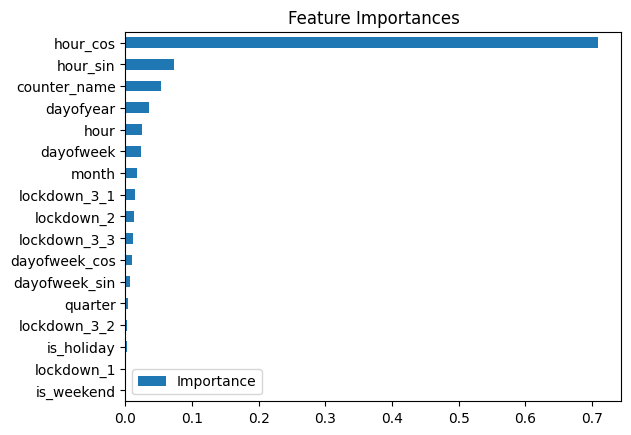

In [36]:
fi.sort_values(by="Importance").plot(kind="barh", title="Feature Importances")

# Forecast on Test

In [37]:
test["prediction"] = reg.predict(X_test)

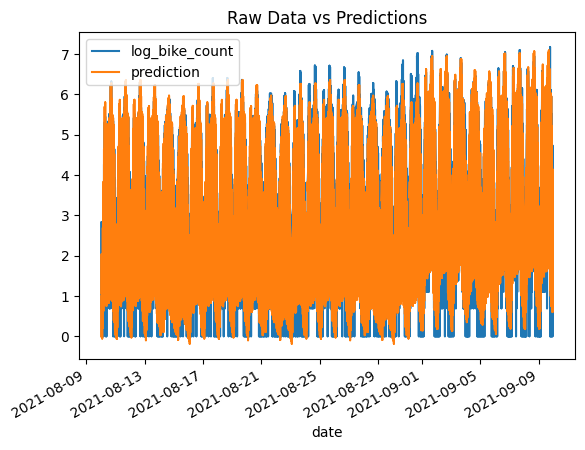

In [38]:
ax = test[["log_bike_count"]].plot()
test["prediction"].plot(ax=ax)
plt.legend()
ax.set_title("Raw Data vs Predictions")
plt.show()

In [39]:
test.head()

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,is_holiday,lockdown_1,lockdown_2,lockdown_3_1,lockdown_3_2,lockdown_3_3,prediction
date,,,,,,,,,,,,,,,,,,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147,5,1,3,8,222,0,0.965926,2.588190e-01,0.781831,0.62349,0,0,0,0,0,0,0.969528
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612,6,1,3,8,222,0,1.000000,6.123234e-17,0.781831,0.62349,0,0,0,0,0,0,1.123409
2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147,7,1,3,8,222,0,0.965926,-2.588190e-01,0.781831,0.62349,0,0,0,0,0,0,1.179829
2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000,9,1,3,8,222,0,0.707107,-7.071068e-01,0.781831,0.62349,0,0,0,0,0,0,0.753770
2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147,10,1,3,8,222,0,0.500000,-8.660254e-01,0.781831,0.62349,0,0,0,0,0,0,0.851618


<Axes: xlabel='date'>

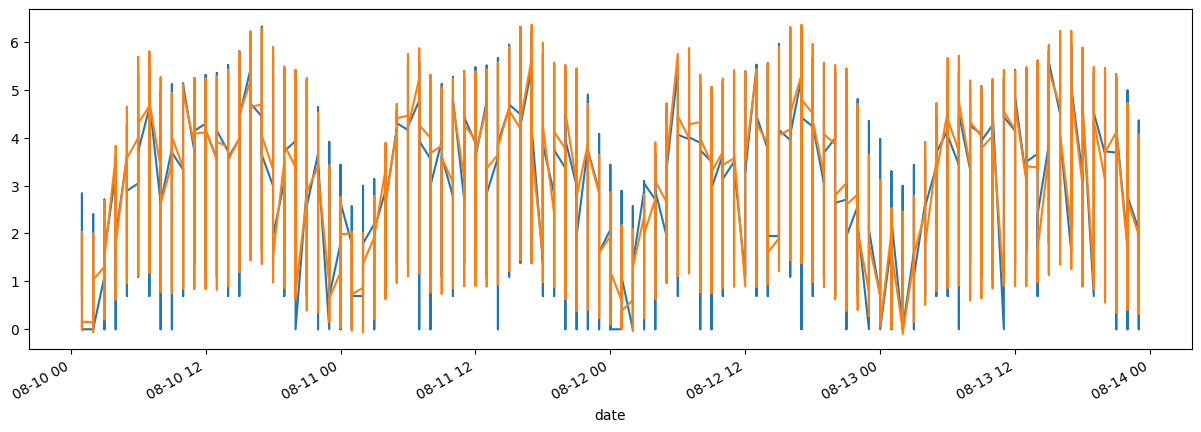

In [40]:
test.loc[(test.index > "2021-08-7") & (test.index < "2021-08-14")][
    "log_bike_count"
].plot(figsize=(15, 5))
test.loc[(test.index > "2021-08-7") & (test.index < "2021-08-14")]["prediction"].plot(
    figsize=(15, 5)
)

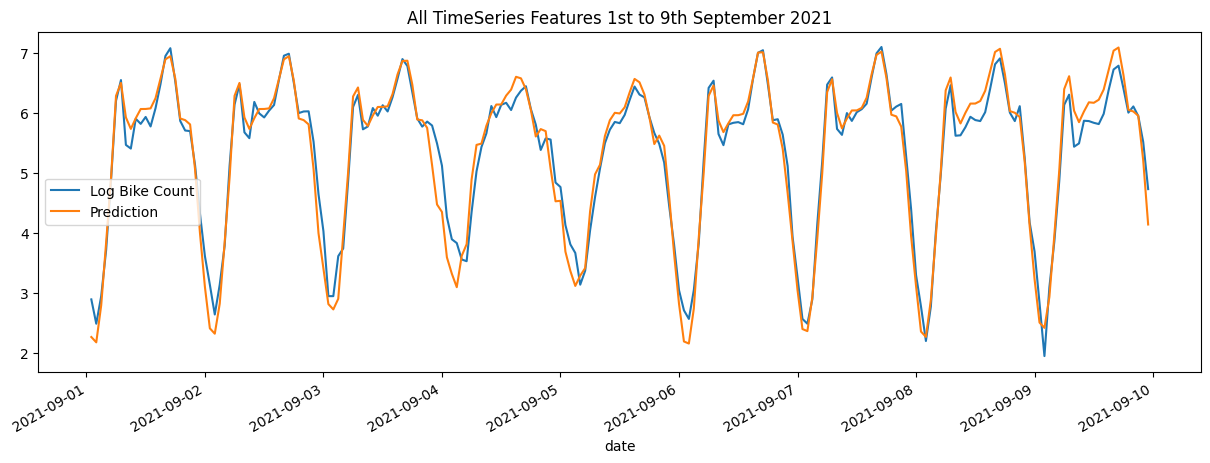

In [41]:
# Filter the dataframe for the given counter name and date range
filtered_data = test[
    (test["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (test.index > "2021-09-1")
    & (test.index < "2021-09-10")
]

# Plot the log_bike_count
filtered_data["log_bike_count"].plot(figsize=(15, 5), label="Log Bike Count")

# Plot the prediction
filtered_data["prediction"].plot(figsize=(15, 5), label="Prediction")

# Add legend to differentiate the plots
plt.legend()
plt.title("All TimeSeries Features 1st to 9th September 2021")
# Show the plot
plt.show()

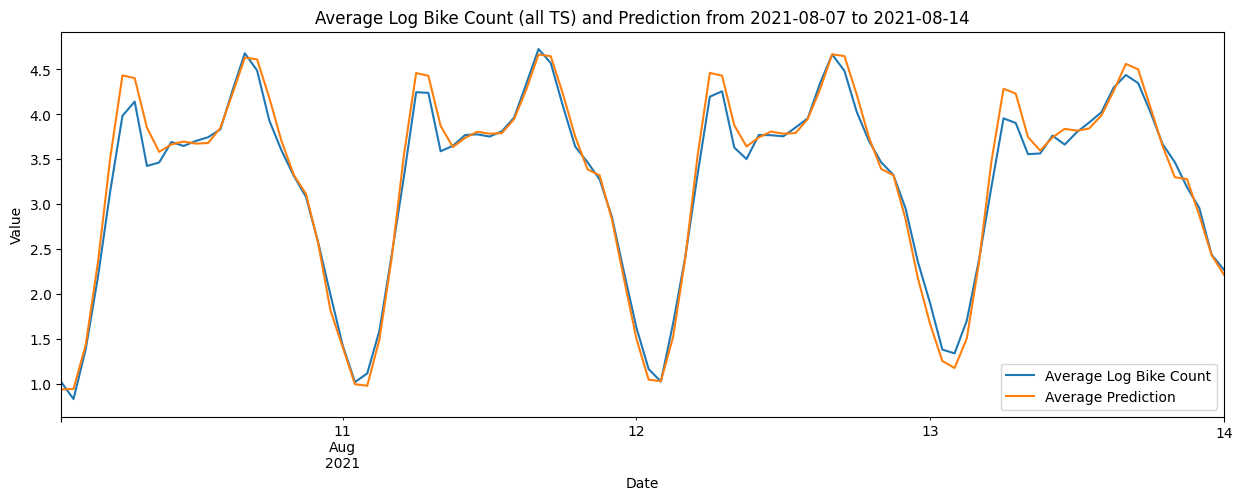

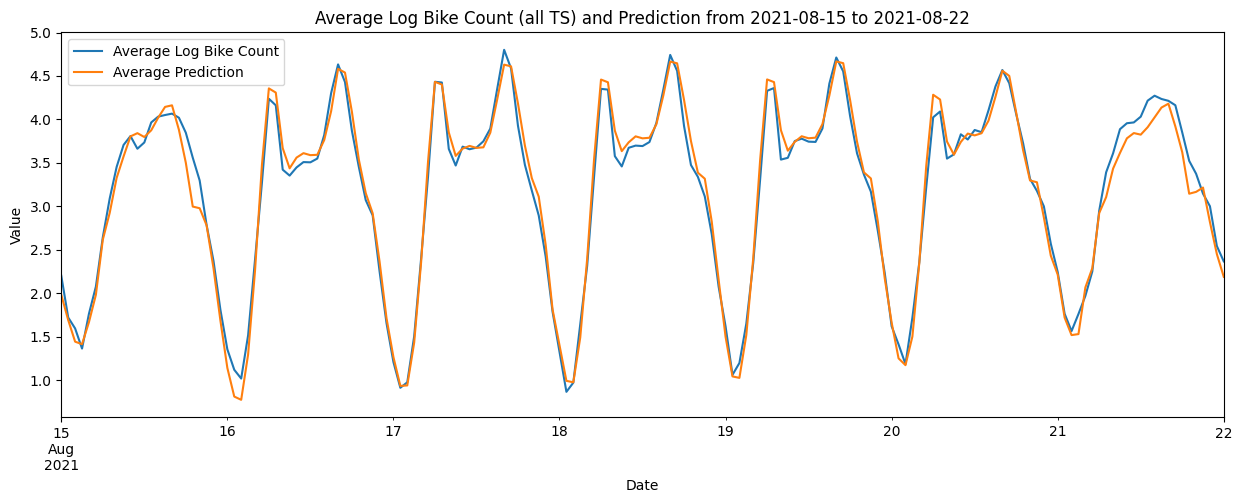

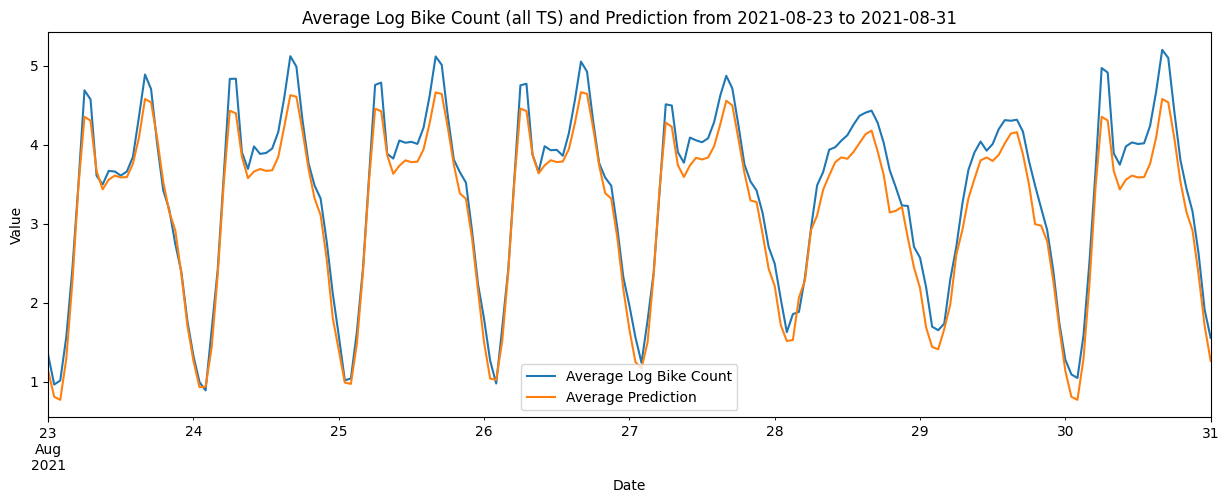

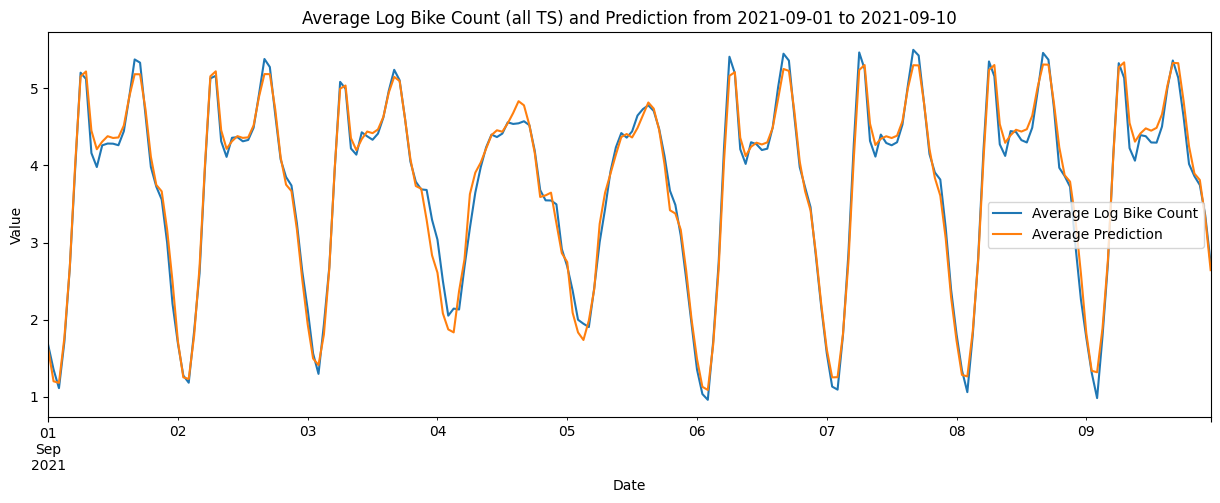

In [52]:
date_ranges = [
    ("2021-08-07", "2021-08-14"),
    ("2021-08-15", "2021-08-22"),
    ("2021-08-23", "2021-08-31"),
    ("2021-09-01", "2021-09-10"),
]

# Loop over each date range and create separate plots
for i, (start_date, end_date) in enumerate(date_ranges, start=1):
    # Filter the data for the given date range
    date_filtered_data = test[(test.index >= start_date) & (test.index <= end_date)]

    # Select only the numeric columns for averaging
    numeric_cols = date_filtered_data.select_dtypes(include=[np.number])

    # Group by the index (date) and calculate the mean for each numeric column
    average_data = numeric_cols.groupby(numeric_cols.index).mean()

    # Set up the figure for plotting
    plt.figure(figsize=(15, 5))

    # Plot the average log_bike_count
    average_data["log_bike_count"].plot(label="Average Log Bike Count")

    # Plot the average prediction
    average_data["prediction"].plot(label="Average Prediction")

    # Add labels and title
    plt.xlabel("Date")
    plt.ylabel("Value")
    title = f"Average Log Bike Count (all TS) and Prediction from {start_date} to {end_date}"
    plt.title(title)

    # Add legend to differentiate the plots
    plt.legend()

    # Filename: remove non-alphanumeric characters, replace spaces with underscores
    filename = re.sub(r"\W+", "", title.replace(" ", "_")) + ".png"

    # Save the figure
    plt.savefig(filename)

    # Show the plot
    plt.show()

In [42]:
rmse_test = mean_squared_error(
    test["log_bike_count"], test["prediction"], squared=False
)
print(rmse_test)

0.42839758662117466


In [43]:
test

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,is_holiday,lockdown_1,lockdown_2,lockdown_3_1,lockdown_3_2,lockdown_3_3,prediction
date,,,,,,,,,,,,,,,,,,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147,5,1,3,8,222,0,0.965926,2.588190e-01,0.781831,0.623490,0,0,0,0,0,0,0.969528
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612,6,1,3,8,222,0,1.000000,6.123234e-17,0.781831,0.623490,0,0,0,0,0,0,1.123409
2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147,7,1,3,8,222,0,0.965926,-2.588190e-01,0.781831,0.623490,0,0,0,0,0,0,1.179829
2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000,9,1,3,8,222,0,0.707107,-7.071068e-01,0.781831,0.623490,0,0,0,0,0,0,0.753770
2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147,10,1,3,8,222,0,0.500000,-8.660254e-01,0.781831,0.623490,0,0,0,0,0,0,0.851618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,6.100319,6,3,3,9,252,0,1.000000,6.123234e-17,0.433884,-0.900969,0,0,0,0,0,0,5.727059
2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,4.983607,10,3,3,9,252,0,0.500000,-8.660254e-01,0.433884,-0.900969,0,0,0,0,0,0,4.862087
2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,5.389072,15,3,3,9,252,0,-0.707107,-7.071068e-01,0.433884,-0.900969,0,0,0,0,0,0,5.148247


In [92]:
test["error"] = np.abs(test["log_bike_count"] - test["prediction"])

In [93]:
test["error"]

date
2021-08-10 05:00:00    0.276381
2021-08-10 06:00:00    0.024796
2021-08-10 07:00:00    0.486682
2021-08-10 09:00:00    0.753770
2021-08-10 10:00:00    0.158470
                         ...   
2021-09-09 06:00:00    0.373260
2021-09-09 10:00:00    0.121520
2021-09-09 15:00:00    0.240824
2021-09-09 22:00:00    0.099011
2021-09-09 23:00:00    0.474420
Name: error, Length: 41608, dtype: float64

In [94]:
test["Date"] = test.index.date

In [95]:
test.groupby("Date")["error"].mean().sort_values(ascending=True).head(5)

Date
2021-08-19    0.264393
2021-08-11    0.271788
2021-08-20    0.272740
2021-08-18    0.273394
2021-08-17    0.274400
Name: error, dtype: float64

# Hyperparameter tuning and cross validation

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
param_grid = {
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 2, 3],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

In [ ]:
grid_search = GridSearchCV(
    estimator=reg, param_grid=param_grid, cv=tscv, verbose=10, n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

In [ ]:
best_reg = xgb.XGBRegressor(
    tree_method="hist",
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    min_child_weight=best_params["min_child_weight"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    enable_categorical=True,
)

In [ ]:
best_reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10,
    verbose=10,
)

In [ ]:
y_hat_xgb = best_reg.predict(X_train)
rmse_xgb_train = mean_squared_error(y_train, y_hat_xgb, squared=False)
print("XGB Train:", rmse_xgb_train)

In [ ]:
y_pred_xgb = best_reg.predict(X_test)
rmse_xgb_test = mean_squared_error(y_test, y_pred_xgb, squared=False)
print("XGB Test:", rmse_xgb_test)

In [45]:
X_test

,counter_name,hour,dayofweek,quarter,month,dayofyear
date,,,,,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,5,1,3,8,222
2021-08-10 06:00:00,28 boulevard Diderot E-O,6,1,3,8,222
2021-08-10 07:00:00,28 boulevard Diderot E-O,7,1,3,8,222
2021-08-10 09:00:00,28 boulevard Diderot E-O,9,1,3,8,222
2021-08-10 10:00:00,28 boulevard Diderot E-O,10,1,3,8,222
...,...,...,...,...,...,...
2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,6,3,3,9,252
2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,10,3,3,9,252
2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,15,3,3,9,252


Training a model for each counter_name

In [36]:
models = {}

In [37]:
best_params = {
    "colsample_bytree": 0.9,
    "learning_rate": 0.1,
    "max_depth": 5,
    "min_child_weight": 2,
    "n_estimators": 500,
    "subsample": 0.9,
}

In [41]:
new_features = ["hour", "dayofweek", "quarter", "month", "dayofyear"]

In [42]:
for counter in train["counter_name"].unique():
    train_subset = train[train["counter_name"] == counter]

    X_train = train_subset[new_features]
    y_train = train_subset["log_bike_count"]

    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train)

    models[counter] = model

In [88]:
predictions_df = pd.DataFrame()

In [89]:
for counter in test["counter_name"].unique():
    test_subset = test[test["counter_name"] == counter]

    if counter in models:
        X_test = test_subset[new_features]
        pred = models[counter].predict(X_test)
        pred_df = pd.DataFrame(
            {"counter_name": counter, "log_bike_count": pred}, index=test_subset.index
        )
        predictions_df = pd.concat([predictions_df, pred_df])

In [90]:
predictions_df

,counter_name,log_bike_count
date,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.757568
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.442927
2021-08-10 07:00:00,28 boulevard Diderot E-O,1.316876
2021-08-10 09:00:00,28 boulevard Diderot E-O,1.231740
2021-08-10 10:00:00,28 boulevard Diderot E-O,1.315687
...,...,...
2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,4.783931
2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,4.255026
2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,4.508782


In [79]:
test

,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear
date,,,,,,,
2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147,5,1,3,8,222
2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612,6,1,3,8,222
2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147,7,1,3,8,222
2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000,9,1,3,8,222
2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147,10,1,3,8,222
...,...,...,...,...,...,...,...
2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,6.100319,6,3,3,9,252
2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,4.983607,10,3,3,9,252
2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,5.389072,15,3,3,9,252


In [81]:
test_reset = test.reset_index()
predictions_reset = predictions_df.reset_index()

In [82]:
merged_df = test_reset.merge(predictions_reset, on=[
                             "counter_name", "date"], how="left")

In [83]:
merged_df

,date,counter_name,log_bike_count,hour,dayofweek,quarter,month,dayofyear,prediction
0,2021-08-10 05:00:00,28 boulevard Diderot E-O,0.693147,5,1,3,8,222,0.757568
1,2021-08-10 06:00:00,28 boulevard Diderot E-O,1.098612,6,1,3,8,222,1.442927
2,2021-08-10 07:00:00,28 boulevard Diderot E-O,0.693147,7,1,3,8,222,1.316876
3,2021-08-10 09:00:00,28 boulevard Diderot E-O,0.000000,9,1,3,8,222,1.231740
4,2021-08-10 10:00:00,28 boulevard Diderot E-O,0.693147,10,1,3,8,222,1.315687
...,...,...,...,...,...,...,...,...,...
41603,2021-09-09 06:00:00,254 rue de Vaugirard SO-NE,6.100319,6,3,3,9,252,4.783931
41604,2021-09-09 10:00:00,254 rue de Vaugirard SO-NE,4.983607,10,3,3,9,252,4.255026
41605,2021-09-09 15:00:00,254 rue de Vaugirard SO-NE,5.389072,15,3,3,9,252,4.508782
41606,2021-09-09 22:00:00,254 rue de Vaugirard SO-NE,3.091042,22,3,3,9,252,2.501501


In [84]:
rmse = np.sqrt(mean_squared_error(merged_df["log_bike_count"], merged_df["prediction"]))
print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 0.4083974134480387
